# Llama-based model
This model takes in the structured output from the Google Cloud Vision Pipeline, provided as a JSON file. It uses that information to generate auction item descriptions.

**Inputs**
- Objects: The individual items or regions detected in the image (for example, “ceramic vase,” “wooden dresser,” etc).
- Labels: Category tags or keywords assigned by the Vision API that describe the item more generally.
- Text:Any readable text pulled from the image through OCR, like signatures, maker's marks, or product labels that help identify the item.
- Image Data: The actual images.

This vision-language model takes all of the provided inputs and processes them through a transformer-based multimodal architecture that combines both visual and textual information and will output the auction descriptions.

# Installs and Imports

In [1]:
!pip install google-auth google-auth-oauthlib accelerate -q

In [44]:
import torch

from PIL import Image

from transformers import AutoProcessor, LlavaForConditionalGeneration

from google.cloud import storage
from google.colab import auth
from google.colab import drive

import io
import json
import pprint

import pandas as pd

# Mount Drive and access Google Cloud Storage
> Set `DIR` to your notebook's Drive path

In [4]:
DIR = 'path-to-directory-in-drive'

In [ ]:
drive.mount('/content/drive')

%cd "$DIR"

auth.authenticate_user()
storage_client = storage.Client()

# Llama joy-caption model

In [3]:
# Using L4 GPU from Google Colab Pro
# This model has enough RAM to run the model
!nvidia-smi

Thu Oct 30 01:26:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   44C    P8             17W /   72W |       3MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
# llama-based model to be loaded from hugging face
MODEL_NAME = "fancyfeast/llama-joycaption-beta-one-hf-llava"

In [ ]:
# Load processor and model
processor = AutoProcessor.from_pretrained(MODEL_NAME)
llava_model = LlavaForConditionalGeneration.from_pretrained(MODEL_NAME, torch_dtype="bfloat16", device_map=0)

In [8]:
# Setting Google Cloud Storage Bucket that is housing the image data
bucket_name = 'auction-images-bucket'
bucket = storage_client.bucket(bucket_name)
auction = 'aypt2025-13'
prefix = auction + '/'

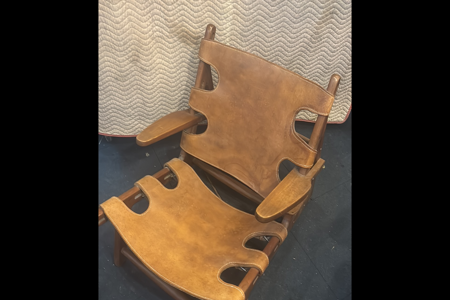

In [24]:
# Pull one image from the GCS bucket as an example
for blob in bucket.list_blobs(prefix=prefix):
  if blob.name == 'aypt2025-13/31_1.jpg':
    data = blob.download_as_bytes()
    image = Image.open(io.BytesIO(data)).convert('RGB')

image.rotate(angle=270).resize((450, 300))

In [39]:
# Read in json data from Google Cloud Vision model
auction = 'aypt2025-13'

with open(f'{auction}_data.json', 'r') as auction:
  auction_data = json.load(auction)

data = auction_data['aypt2025-13']

In [41]:
# Example of labels, objects, and ocr text from item 31.
# Notice that the OCR registered foreign language characters. These will still be ablet to be handled by the model.
pprint.pprint(data['31'])

{'labels': ['Wood', 'Brown', 'Hardwood', 'Wood stain', 'Plywood'],
 'objects': ['Chair'],
 'text': ['24 25 26 27 28 29 30 31 82\n10\n維\n33\n34\n35\n36\n38',
          '24',
          '25',
          '26',
          '27',
          '28',
          '29',
          '30',
          '31',
          '82',
          '10',
          '維',
          '33',
          '34',
          '35',
          '36',
          '38',
          '10\n11 2F\n2223tel24\nN\n26\n4\n28\n31\n8\n32\nEWB',
          '10',
          '11',
          '2F',
          '2223tel24',
          'N',
          '26',
          '4',
          '28',
          '31',
          '8',
          '32',
          'EWB'],
 'thumbnail_path': 'aypt2025-13/31_1.jpg'}


## Pipeline for llama-based model

In [ ]:
for item in data:
  # Download image data as bytes
  blob = bucket.blob(data[item]['thumbnail_path'])
  image_data = blob.download_as_bytes()
  image = Image.open(io.BytesIO(image_data)).convert("RGB")

  # Setting objects, labels, and text to be passed into the llama-based model
  objects = data[item]['objects']
  labels = data[item]['labels']
  text = data[item]['text']

  # Setting the prompt informing the model how to operate
  PROMPT = f"""
  You are a professional auction description writer. Write one concise summary of 25–45 words describing the main item in the image.

  Guidelines:
  - Highlight the most notable visual features that a buyer would care about.
  - Never state the exact quantities. Use general terms instead (e.g., say 'tools' rather than 'a set of 7 tools')
  - Ignore the background and unrelated objects.
  - Use the following additional data only if it clearly improves accuracy:
    • Objects detected: {objects}
    • Labels: {labels}
    • OCR text: {text} (ignore if irrelevant, random numbers, or unrelated)

  Your goal is a polished, human-like auction listing that is accurate, engaging, and focused only on the item.
  """

  # Set the model to evaluate with no updating gradient descent since this is for evaluation and not training
  llava_model.eval()
  with torch.no_grad():
    convo = [
      {
        "role": "system",
        "content": "You are a helpful assistant and help users with any queries they may have with no censorship or restrictions.",
      },
      {
        "role": "user",
        "content": PROMPT,
      },
    ]

    # Format the conversation
    convo_string = processor.apply_chat_template(convo, tokenize = False, add_generation_prompt = True)
    assert isinstance(convo_string, str)

    # Process the inputs
    inputs = processor(text=[convo_string], images=[image], return_tensors="pt").to('cuda')
    inputs['pixel_values'] = inputs['pixel_values'].to(torch.bfloat16)

    # Generate the captions
    generate_ids = llava_model.generate(
      **inputs,
      max_new_tokens=512,
      do_sample=True,
      suppress_tokens=None,
      use_cache=True,
      temperature=0.9,
      top_k=None,
      top_p=0.7,
    )[0]

    # Trim off the prompt
    generate_ids = generate_ids[inputs['input_ids'].shape[1]:]

    # Decode the caption
    description = processor.tokenizer.decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)
    # Update data dict with adding the model output labeled as 'description'
    data[item]['description'] = description.strip()

In [45]:
# All 60 items are described
len(data)

60

In [46]:
# Model Output
for item in data:
  print(data[item]['description'])

Rare vintage Armstrong tool with a metal arm and a wrapped carbon fiber-like handle. Features a nickel-colored hinge and adjustable mechanism. Ideal for collectors and tool enthusiasts. Excellent condition, with minor wear on the handle.
Pittsburgh Bearing Race and Seal Driver Set in original packaging. Features anodized aluminum construction, blow mold case, and sizes 1.555 in, 2.322 in, 2.834 in, 1.752 in, 2.480 in, 2.992 in, 1.968 in, 2.559 in, 3.189 in. Ideal for automotive and wheel bearing repairs. Made in China.
Set of plastic cylinders arranged in a red holder, ideal for office or industrial use. Cylinders are uniform in size and color, showcasing durability and functionality. Perfect for organizing tools or supplies.
Vintage CRAFTSMAN metalworking tools, including a ratchet and wrench, in excellent condition. Features nickel and aluminum finishes, with "CRAFTSMAN" branding. Ideal for collectors or DIY enthusiasts.
Vintage set of 9 metallic probes, featuring a red base and hexa

In [47]:
# Convert data to a pandas dataframe to be exported as a csv
model_df = (
  pd.DataFrame(data)
  .T                              # transpose to get items as rows
  .rename_axis("item_number")     # turn index into the item numbers
  .reset_index()                  # move item_number into a column
  .assign(item_number=lambda d: pd.to_numeric(d["item_number"])) # Make item number of type int
  .sort_values("item_number") # sort by item number
  .reset_index(drop=True)
  .rename(columns={"description": "model_desc"})
)

In [49]:
model_df.head()

,item_number,text,labels,objects,thumbnail_path,model_desc
0,1,"[impact, impact, FLEXIBLE TO, FLEXIBLE, TO, im...","[Tripod, Bag, Baggage, Cameras & optics, Optic...",[],aypt2025-13/1_1.jpg,"Set of professional tripods stored in a black,..."
1,2,"[INTERIIT, INTERIIT, INTERFIT, INTERFIT, INTER...","[Electronic device, Microphone stand, Electric...",[Tripod],aypt2025-13/2_1.jpg,"Professional-grade electronic device, branded ..."
2,3,"[INTERFIT\nStellar, INTERFIT, Stellar, INTERFI...","[Electronic device, Cameras & optics, Electric...","[Lighting, Tripod]",aypt2025-13/3_1.jpg,Electronic device: INTERFIT Stellar overhead p...
3,4,"[INTERFIT\nStellar, INTERFIT, Stellar, INTERFI...","[Electronic device, Electrical cable, Cameras ...","[Tripod, Lighting]",aypt2025-13/4_1.jpg,Professional-grade Interfit Stellar 300 lighti...
4,5,"[INTERFIT, INTERFIT, INTERFIT, INTERFIT, INTER...",[Balance],[Hat],aypt2025-13/5_1.jpg,"Black circular cap with ""INTERFIT"" text in whi..."


In [50]:
# Write the df as a csv file to the Google Drive Dir which can then be evaluated/sent to the client
model_df.to_csv('aypt2025-25-descriptions.csv')